# **Facial Recognition Project**

Faces convey a wealth of information that is critical to social interactions, such as identity and emotion. Face recognition is a critical skill that develops early and supports our social abilities. Emotion recognition is perhaps second to face recognition in enabling social reasoning. People’s facial expressions give us important yet subtle clues regarding how they are feeling and reacting to ongoing events.

Therefore, in our project, we use Machine Learning to help empowers psychologists to be in a privileged position to better understand others and anticipate actions and statements that will help to guide, build consensus, and lead others.

(alot of fluff, pls review the description)

# Imports and Constants

### Imports

In [ ]:
import cv2 # OpenCV2
import matplotlib.pyplot as plt
import numpy as np
import os # For Directories
from skimage.metrics import structural_similarity # Identify duplicates
from tqdm import tqdm # For loop progress bar

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

### Constants

In [ ]:
emotions = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise'] # All emotions (class variable)
IMG_SIZE= (48, 48) # Our resolution to resize images
TRAIN_DIR = ('Training/Training/') # Path to Training Set
TEST_DIR = ('Testing/Testing/') # Path to Testing Set
RANDOM_SEED = 123 # For reproducibility

# Step 1. Download Facial Recognition Dataset

This dataset contains folders pertaining to different expressions of the human face, namely , Surprise, Anger, Happiness, Sad, Neutral, Disgust, Fear.

The training set consists of 28,079 samples in total with the testing set consisting of 7,178 samples in total. The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image.

Credits: [Kaggle](https://www.kaggle.com/datasets/apollo2506/facial-recognition-dataset)

### Download Dataset

In [ ]:
# For convenience, we have hosted the dataset on our Github repository. 
!wget https://raw.githubusercontent.com/Jade-P/MLGroupProject/main/archive.zip
!unzip archive.zip

# Step 2. Initialise Training and Testing Set


### Initialise function to load image data

In [ ]:
def load_data(dir_path, IMG_SIZE):
    """
    Load image data, given a directory of image files.

    Parameters:
    1. dir_path (str): Directory of image files
    2. IMG_SIZE ((int, int)): Resolution to resize image

    Returns:
    1. X (list(Image)): List of image data (represented by arrays of integers) 
    2. y (list(int)): Corresponding list of encoded emotions
    3. labels (dict(int, string)): Mapping of encoded emotions to their respective emotions
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(emotions)):
        labels[i] = path
        for file in os.listdir(dir_path + path):
            img = cv2.imread(dir_path + path + '/' + file, cv2.IMREAD_GRAYSCALE)
            img = img.astype('float32') / 255 # NORMALIZES PIXELS 
            resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
            X.append(resized)
            y.append(i)
        i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.\n')
    return X, y, labels

### Load Training and Testing data

In [ ]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE) 

100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


28273 images loaded from Training/Training/ directory.



100%|██████████| 6/6 [00:00<00:00, 13.79it/s]

7067 images loaded from Testing/Testing/ directory.



### Quick check

In [ ]:
print(f"The training labels are {train_labels}") # Check training labels
print(f"The size of the training set is {X_train.shape}") # Check size of training set

The training labels are {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}
The size of the training set is (28273, 48, 48)


# Step 3. Data Exploration

Next, we conduct data exploration. It is a process where we look at and understand their data with statistical and visualization methods. This step helps identifying patterns and problems in the dataset, as well as deciding which model or algorithm to use in subsequent steps.

## Step 3.1. Count number of images for each emotion

Adapted from [Gotam Dahiya](https://www.kaggle.com/code/apollo2506/facial-recognition)

### Generate table of no. of images for each emotion


In [ ]:
import pandas as pd

_, train_count = np.unique(y_train,return_counts=True)
_, test_count = np.unique(y_test,return_counts=True)

df = pd.DataFrame(data = (train_count,test_count))
df = df.T
df['Name'] = emotions
data = df.rename(columns={0: "train", 1: "test", "Name" : "emotion"})
data

,train,test,emotion
0,3995,958,Angry
1,4097,1024,Fear
2,7215,1774,Happy
3,4965,1233,Neutral
4,4830,1247,Sad
5,3171,831,Suprise


### Visualise no. of images for each emotion (pie chart)

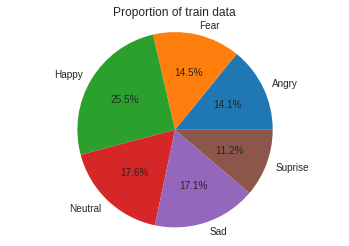

In [ ]:
plt.pie(train_count,
       explode=(0,0,0,0,0,0),
       labels=emotions,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Proportion of train data")
plt.show()

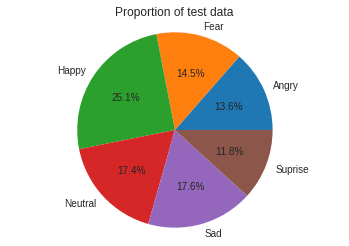

In [ ]:
plt.pie(test_count,
       explode=(0,0,0,0,0,0),
       labels=emotions,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Proportion of test data")
plt.show()

###Visualise no. of images for each emotion (bar chart)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


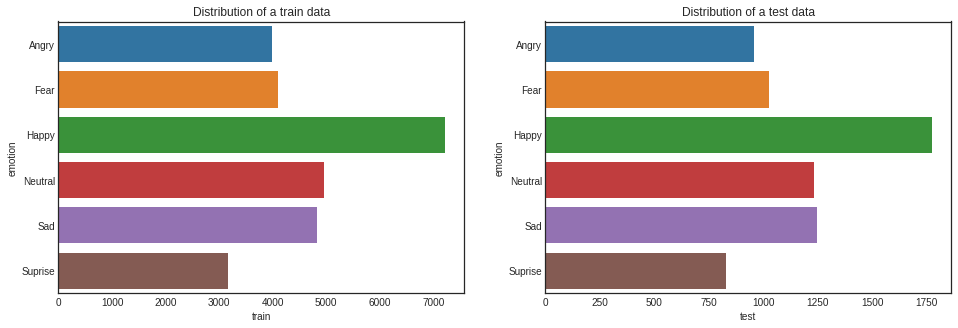

In [ ]:
import seaborn as sns

plt.style.use('seaborn-white')
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(data["train"], data["emotion"], ax=ax[0])
ax[0].set_title("Distribution of a train data")
sns.barplot(data["test"], data["emotion"], ax=ax[1])
ax[1].set_title("Distribution of a test data")
plt.show()

These graphs show that each emotion have different number of images. 'Happy' has the most number of images, while 'Surprise' has the least number of images. We take note of the difference in the number of images for each emotion during model building. 

## Step 3.2 Verify the size of the images

The dataset claims that all images are 48x48. Let's verify if this claim is true.

In [ ]:
widths = dict()
heights = dict()

for img in X_train:
  width, height = img.shape
  widths[width] = widths.get(width,0)+1
  heights[height] = heights.get(height,0)+1

In [ ]:
print(widths)
print(heights)

{48: 28273}
{48: 28273}


Every image is in size of 48 * 48, so we don't need to resize any of the images.

## Step 3.3 Visualise samples of the images

Since image data is encoded in integer arrays, let's interpret these arrays to give us a quick glance at the input images.

Adapted from [Basel Ayman](https://www.kaggle.com/code/basel99/facial-recognition)

### Initialise function to plot images

In [ ]:
def plot_samples(X, y, labels_dict, n=50):

    """
    Plot images, given image data and their corresponding labels.

    Parameters:
    1. X (list(Image)): List of image data (represented by arrays of integers) 
    2. y (list(int)): Corresponding list of encoded emotions
    3. labels (dict(int, string)): Mapping of encoded emotions to their respective emotions
    4. n (int): Number of images to plot

    Returns:
    None
    """
   
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

### Plot images

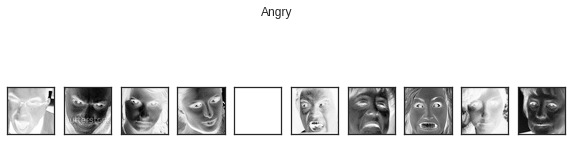

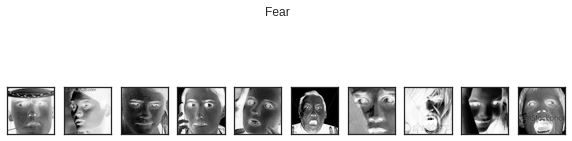

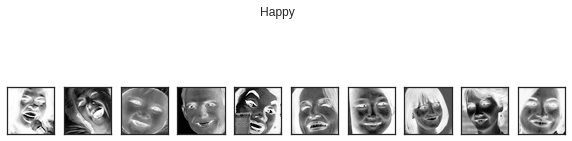

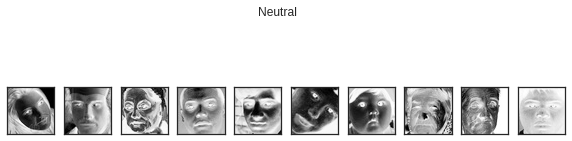

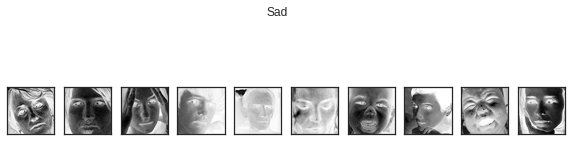

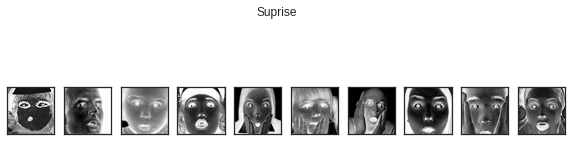

In [ ]:
plot_samples(X_train, y_train, train_labels, 10)

# Step 4. Data Preprocessing

Now that we have a clearer understanding of our dataset, let's clean our dataset before building our model. 

We learnt that, even with a perfect model, garbage in garbage out!


## Step 4.1 Remove Duplicates

Let's check if there are duplicates in our dataset. For image data, duplicates are likely not real data that coincidentally have values that are identical. Thus, duplicates are an extreme case of nonrandom sampling, and they bias our fitted model. Including them will essentially lead to the model overfitting this particular duplicate image.

Adapted from [Mizy's Log](https://mizykk.tistory.com/55)

### Get image size

In [ ]:
def getImgData(path):
  """
  Return size of image files.

  Parameters:
  1. path (string): Directory of images
  
  Returns:
  1. img_data (DataFrame): Contains filenames and their corresponding size
  """
  
  image_list = os.listdir(path)
  img_size = list(map(lambda x: os.path.getsize(path + '/' + x), image_list))
  img_data = pd.DataFrame({'filename':image_list, 'size':img_size})
  print('number of images :', len(img_data))
  return img_data

### Identify duplicate images

We use structural similarity to compare similarity of images.
Then, we see if similar images are similar enough to be removed.


In [ ]:
def CompareImage(imageA, imageB):
    """
    Compare two images for structural similarity.

    Parameters:
    1. imageA (Image): first image to compare
    2. imageB (Image): second image to compare.

    Returns:
    1. score (float): Structural similarity score of the two input images.
    """

    # Grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    
    # Check Image structure
    if len(grayA)==len(grayB):
        (score, diff) = structural_similarity(grayA, grayB, full=True)

    return score

In [ ]:
def getDuplicates(img_data):
  """
  Identity duplicate images.

  Parameters:
  1. img_data (DataFrame): Contains filenames and their corresponding size

  Returns:
  1. delete (dict): Contains mapping of images and their corresponding duplicates to delete.

  """

  # Photo Value Counts
  imgsize_cnts = pd.DataFrame({'size':img_data['size'].value_counts().index, 'size_counts':img_data['size'].value_counts().values})   
  img_data = pd.merge(img_data, imgsize_cnts, how = 'left', on = 'size')
  SimilarSizeData = imgsize_cnts[imgsize_cnts['size_counts'] > 1]

  delete = dict()

  for i in range(len(SimilarSizeData)):
    temp = img_data[img_data['size']==SimilarSizeData['size'][i]].reset_index(drop = True).sort_values(['filename'])

    for j in range(len(temp) - 1):
      filenameA = temp['filename'][j]
      compared = False

      for key in delete:
        if (filenameA in delete[key]):
          compared = True
          break
      
      if compared:
        continue

      for k in range(j+1, len(temp)):
        filenameB = temp['filename'][k]
        
        imageA = cv2.imread(path+'/'+filenameA)
        imageB = cv2.imread(path+'/'+filenameB)

        score = CompareImage(imageA, imageB)
        
        if (score == 1 or score > 0.6):
          if filenameA not in delete:
            delete[filenameA] = [filenameB]
          else:
            delete[filenameA].append(filenameB)
          if (score < 1):
            print(filenameA + ", " + filenameB)
            print("score: " + str(score))
          
    total = [len(value) for key, value in delete.items()]
    print(str(sum(total)) + " duplicates found")

    return delete

### Plot a sample of duplicates 
Let's confirm if identified duplicates are truly duplicates, through visual inspection.

In [ ]:
def plotDuplicates(path, delete):

    """
    Plot duplicate images.

    Parameters:
    1. path (string): Directory of images containing duplicates.
    2. delete (dict): Contains mapping of images and their corresponding duplicates to delete.

    Returns:
    None

    """

    plt.figure(0, figsize=(8,4))
    cpt = 0

    n = 8
    
    for key in delete:
      if (n == 0):
        break

      cpt += 1
      ax = plt.subplot(4,6,cpt)
      ax.set_title(key)
      img = cv2.imread(path+"/"+ key)
      plt.tick_params(labelleft=False,labelbottom=False)
      plt.imshow(img,cmap="gray")

      for file in delete[key]:
        cpt += 1
        ax = plt.subplot(4,6,cpt)
        ax.set_title(file)

        img = cv2.imread(path+"/"+ file)
        plt.tick_params(labelleft=False,labelbottom=False)
        plt.imshow(img,cmap="gray")
        pass
      
      while (cpt % 4 != 0):
        cpt +=1
      n -= 1

    plt.tight_layout()
    plt.show()

### Remove Images

If the identified duplicates are deemed correctly identified, we can proceed to remove those images from our dataset.  

In [ ]:
def removeDuplicates(path, delete, image_list):

    """
    Remove duplicate images from directory and current image data.

    Parameters:
    1. path (string): Directory of images containing duplicates.
    2. delete (dict): Contains mapping of images and their corresponding duplicates to delete.
    3. image_list (list(Image)): List of image data

    Returns:
    None
    """
    orig_list = image_list
    print("original image number: " + str(len(orig_list)))

    for key in delete:
      for val in delete[key]:
        image_list.remove(val)
    print("updated images number: " + str(len(image_list)))

    remove_cnt = 0

    for key in delete:
      for val in delete[key]:
        os.remove(path + "/" + val)
        remove_cnt +=1

    print(str(remove_cnt) + " number of duplicates removed")

### Putting them all together...

Please repeat this code unless there are '0 duplicates found' for all emotions. Be sure to visually check that the identified duplicates are true duplicates to be delete,

In [ ]:
for emotion in emotions:
  print("Finding for duplicates in class " + emotion + "...")

  path = TRAIN_DIR + emotion
  image_list = os.listdir(path)
  img_data = getImgData(path)
  delete_list = getDuplicates(img_data)
  plotDuplicates(path, delete_list)
  removeDuplicates(path, delete_list, image_list)

Finding for duplicates in class Angry...
number of images : 3991
0 duplicates found


<Figure size 576x288 with 0 Axes>

original image number: 3991
updated images number: 3991
0 number of duplicates removed
Finding for duplicates in class Fear...
number of images : 4093
0 duplicates found


<Figure size 576x288 with 0 Axes>

original image number: 4093
updated images number: 4093
0 number of duplicates removed
Finding for duplicates in class Happy...
number of images : 7215
0 duplicates found


<Figure size 576x288 with 0 Axes>

original image number: 7215
updated images number: 7215
0 number of duplicates removed
Finding for duplicates in class Neutral...
number of images : 4965
0 duplicates found


<Figure size 576x288 with 0 Axes>

original image number: 4965
updated images number: 4965
0 number of duplicates removed
Finding for duplicates in class Sad...
number of images : 4828
0 duplicates found


<Figure size 576x288 with 0 Axes>

original image number: 4828
updated images number: 4828
0 number of duplicates removed
Finding for duplicates in class Suprise...
number of images : 3120
0 duplicates found


<Figure size 576x288 with 0 Axes>

original image number: 3120
updated images number: 3120
0 number of duplicates removed


### Legacy (deprecated)

In [ ]:
import cv2  
from skimage.metrics import structural_similarity

image_list = []

path = TRAIN_DIR + '/Happy'

for f in os.listdir(path):
  image_list.append(f)

img_size = list(map(lambda x: os.path.getsize(path + '/' + x), image_list))

# Find Same Photos
img_data = pd.DataFrame({'filename':image_list, 'size':img_size})

print('number of images :', len(img_data))

number of images : 7215


In [ ]:
img_data

,filename,size
0,Happy-5426.jpg,1705
1,Happy-5903.jpg,1685
2,Happy-6736.jpg,1383
3,Happy-3480.jpg,1374
4,Happy-1272.jpg,2015
...,...,...
7210,Happy-6442.jpg,1878
7211,Happy-2803.jpg,1715
7212,Happy-4684.jpg,1466
7213,Happy-6745.jpg,1484


In [ ]:
# Photo Value Counts
filename_cnts = pd.DataFrame({'filename':img_data['filename'].value_counts().index, 'fn_counts':img_data['filename'].value_counts().values})   
imgsize_cnts = pd.DataFrame({'size':img_data['size'].value_counts().index, 'size_counts':img_data['size'].value_counts().values})   

img_data = pd.merge(img_data, filename_cnts, how = 'left', on = 'filename')
img_data = pd.merge(img_data, imgsize_cnts, how = 'left', on = 'size')

img_data.sample(2)

,filename,size,fn_counts,size_counts
4557,Happy-5741.jpg,1540,1,24
4398,Happy-6026.jpg,1557,1,23


In [ ]:
SimilarSizeData = imgsize_cnts[imgsize_cnts['size_counts'] > 1]

###Use structural similarity to compare similarity of images

In [ ]:
def CompareImage(imageA, imageB):

    # Grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    
    # Check Image structure
    if len(grayA)==len(grayB):
        (score, diff) = structural_similarity(grayA, grayB, full=True)

    return score

In [ ]:
delete = dict()

In [ ]:
for i in range(len(SimilarSizeData)):

    temp = img_data[img_data['size']==SimilarSizeData['size'][i]].reset_index(drop = True).sort_values(['filename'])

    for j in range(len(temp) - 1):
      filenameA = temp['filename'][j]
      compared = False

      for key in delete:
        if (filenameA in delete[key]):
          compared = True
          break
      
      if compared:
        continue

      for k in range(j+1, len(temp)):
        filenameB = temp['filename'][k]
        
        imageA = cv2.imread(path+'/'+filenameA)
        imageB = cv2.imread(path+'/'+filenameB)

        score = CompareImage(imageA, imageB)
        
        if (score == 1 or score > 0.6):
          if filenameA not in delete:
            delete[filenameA] = [filenameB]
          else:
            delete[filenameA].append(filenameB)
          if (score < 1):
            print(filenameA + ", " + filenameB)
            print("score: " + str(score))
          

Happy-2461.jpg, Happy-6680.jpg
score: 0.7168389603349193


### See if similar images are similar enough to be removed

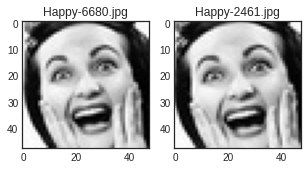

In [ ]:
plt.figure(0, figsize=(5,3))
ax = plt.subplot(1,2,1)
ax.set_title('Happy-6680.jpg')
img1 = cv2.imread(path+"/"+ 'Happy-6680.jpg')
plt.imshow(img1,cmap="gray")

ax = plt.subplot(1,2,2)
ax.set_title('Happy-2461.jpg')
img2 = cv2.imread(path+"/"+ 'Happy-2461.jpg')
plt.imshow(img2,cmap="gray")

In [ ]:
total = [len(value) for key, value in delete.items()]
print(str(sum(total)) + " duplicates found")

129 duplicates found


###Plotting some duplicates to confirm they are the same

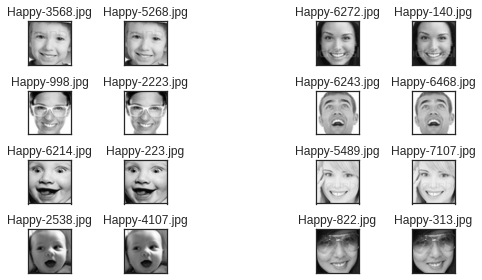

In [ ]:
plt.figure(0, figsize=(8,4))
cpt = 0

n = 8

for key in delete:
  if (n == 0):
    break

  cpt += 1
  ax = plt.subplot(4,6,cpt)
  ax.set_title(key)
  img = cv2.imread(path+"/"+ key)
  plt.tick_params(labelleft=False,labelbottom=False)
  plt.imshow(img,cmap="gray")

  for file in delete[key]:
    cpt += 1
    ax = plt.subplot(4,6,cpt)
    ax.set_title(file)

    img = cv2.imread(path+"/"+ file)
    plt.tick_params(labelleft=False,labelbottom=False)
    plt.imshow(img,cmap="gray")
    pass
  
  if (cpt % 3 != 0):
    cpt +=1
  n -= 1

plt.tight_layout()
plt.show()

In [ ]:
orig_list = image_list

print("original image number: " + str(len(orig_list)))

original image number: 7215


In [ ]:
for key in delete:
  for val in delete[key]:
    image_list.remove(val)

print("updated images number: " + str(len(image_list)))

updated images number: 7086


###Remove images

In [ ]:
for key in delete:
  print("Removing duplicates of " + key)
  for val in delete[key]:
    print(val + " removed")
    os.remove(TRAIN_DIR + "Happy/" + val)

Removing duplicates of Happy-3568.jpg
Happy-5268.jpg removed
Removing duplicates of Happy-6272.jpg
Happy-140.jpg removed
Removing duplicates of Happy-998.jpg
Happy-2223.jpg removed
Removing duplicates of Happy-6243.jpg
Happy-6468.jpg removed
Removing duplicates of Happy-6214.jpg
Happy-223.jpg removed
Removing duplicates of Happy-5489.jpg
Happy-7107.jpg removed
Removing duplicates of Happy-2538.jpg
Happy-4107.jpg removed
Removing duplicates of Happy-822.jpg
Happy-313.jpg removed
Removing duplicates of Happy-3907.jpg
Happy-173.jpg removed
Removing duplicates of Happy-4095.jpg
Happy-2378.jpg removed
Removing duplicates of Happy-2342.jpg
Happy-3371.jpg removed
Removing duplicates of Happy-2818.jpg
Happy-4403.jpg removed
Happy-307.jpg removed
Removing duplicates of Happy-2760.jpg
Happy-598.jpg removed
Removing duplicates of Happy-3730.jpg
Happy-1685.jpg removed
Removing duplicates of Happy-1864.jpg
Happy-3795.jpg removed
Removing duplicates of Happy-876.jpg
Happy-5820.jpg removed
Removing d

## Step 4.2 Remove Outliers

There are some outliers in our dataset. Many of them are faulty images (e.g. image of an error code). Other outliers includes images that does not include a face, or includes more than 1 face.

Unfortunately, these outliers have to be found manually.

Remove image that doesn't look like a face, or includes more than one face. Outliers were found manually.

### All manually identified outliers. To be deleted.

In [ ]:
outliers = {'Angry': [786, 930, 1078, 1596, 1730, 1835, 1866, 2185, 2822, 2903, 3091, 3384, 3714, 3975], 
            'Fear':[768, 562], 
            'Happy': [1414,2541,4488,5326,1091,1817,2039,2226,2250,2819,3964,4123,6270,6441,6627],
            'Neutral':[1058, 2062, 2156, 2657, 2997, 3392, 363, 3767, 3977, 4186, 4352, 4473, 4859], 
            'Sad':[1721, 1891, 1966, 4001],
            'Suprise':[80, 128, 211, 213, 233, 259, 300, 309, 312, 335, 353, 596, 611, 665, 758, 1288, 1499, 2055, 2214, 2276]}

### Plot the identified outliers & Remove them from their directory

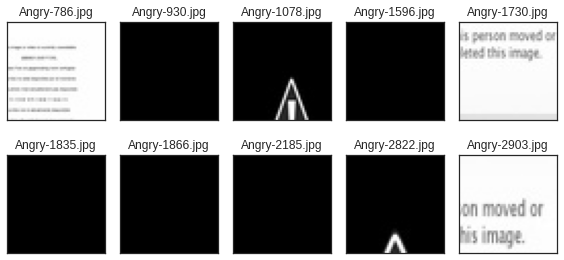

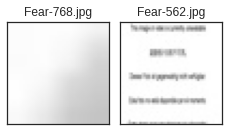

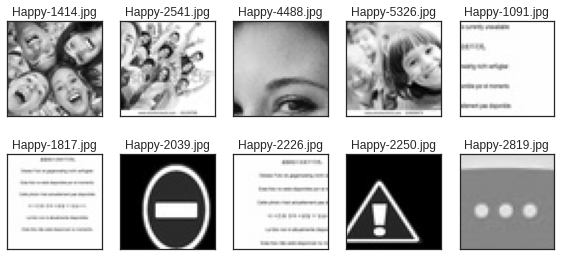

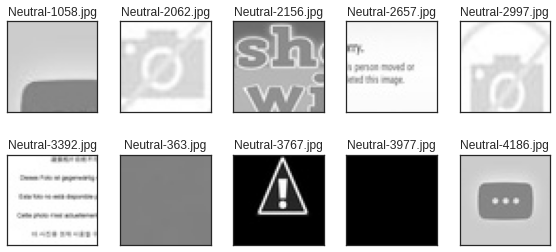

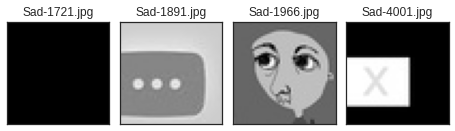

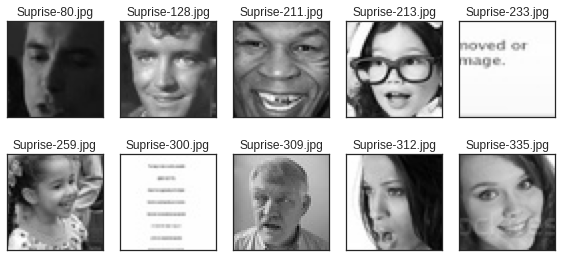

In [ ]:
for emotion in outliers:
  path = TRAIN_DIR + emotion

  plt.figure(0, figsize=(8,4))
  cpt = 0

  n = 10

  for outlier in outliers[emotion]:
    if (n == 0):
      break

    cpt += 1
    ax = plt.subplot(2,5,cpt)
    img_name = emotion + "-" + str(outlier) + ".jpg"
    ax.set_title(img_name)
    img = cv2.imread(path+"/"+ img_name)
    plt.tick_params(labelleft=False,labelbottom=False)
    plt.imshow(img,cmap="gray")

    n -= 1

  plt.tight_layout()
  plt.show()

  #remove outlier
  for outlier in outliers[emotion]:
    os.remove(path + "/" + emotion + "-" + str(outlier) + ".jpg")

### Load Training and Testing set 

After deleting duplicates from our directory, let's load the data from the cleaned directory.


In [ ]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE) # Training set
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE) # Testing set

100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


28144 images loaded from Training/Training/ directory.



### Quick Check

In [ ]:
print(f"The training labels are {train_labels}") # Check training labels
print(f"The size of the training set is {X_train.shape}") # Check size of training set

The training labels are {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}
The size of the training set is (28144, 48, 48)


Over 100 images removed in total! (0.4% of total dataset)

## Step 4.3 Post-preprocessing Data Exploration

Now that duplicate images are removed from the directory, let's reload the dataset and re-explore the data in the cleaned dataset.

### Step 4.3.1. Count number of images for each emotion

Adapted from [Gotam Dahiya](https://www.kaggle.com/code/apollo2506/facial-recognition)

#### Generate table of no. of images for each emotion

In [ ]:
_, train_count = np.unique(y_train,return_counts=True)
_, test_count = np.unique(y_test,return_counts=True)

df = pd.DataFrame(data = (train_count,test_count))
df = df.T
df['Name'] = emotions
data = df.rename(columns={0: "train", 1: "test", "Name" : "emotion"})

### Generate table of no. of images for each emotion

In [ ]:
data_after = df.rename(columns={0: "Training Data", 1: "Testing Data","Name" : "Emotions"})
data_after = data_after.set_index("Emotions")
data_after

,Training Data,Testing Data
Emotions,,
Angry,3977,958
Fear,4091,1024
Happy,7200,1774
Neutral,4952,1233
Sad,4824,1247
Suprise,3100,831


#### Visualise no. of images for each emotion (scatter plot)


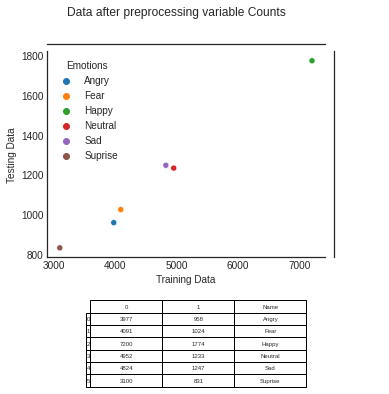

In [ ]:
import seaborn as sns
#preprocessing table 
sns.jointplot(data=data_after, x="Training Data", y="Testing Data",hue = "Emotions")

plt.suptitle('Data after preprocessing variable Counts')
plt.subplots_adjust(left=0.2, bottom=0.4)
table = plt.table(cellText=df.values,
          rowLabels=df.index,
          colLabels=df.columns,
          cellLoc = 'center', rowLoc = 'center',
          transform=plt.gcf().transFigure,
          bbox = ([0.3, 0.1, 0.5, 0.2]))
table.auto_set_font_size(False)
table.set_fontsize(6)
plt.savefig('table.pdf',bbox_inches='tight')

## Step 4.4 Encoding Classes

To support certain model architecture, we choose to use One-hot encoding with the emotion class. 

In [ ]:
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_train

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

## Step 4.5 Normalization

We will normalise the images, to restrict the color domain of the image and to make uniform the range of the color domain for all images. Here is a simple demonstration of normalizing single image. In this project, normalisation will be done when we are building the model.

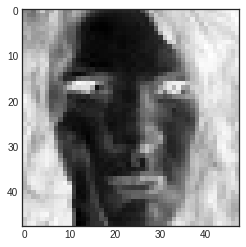

In [ ]:
img = X_train[0]
norm_image = (img - np.min(img)) / (np.max(img) - np.min(img))
plt.imshow(norm_image)

In [ ]:
np.array_equal(img, norm_image)

False

# Step 5. Model Building



In [ ]:
# Input image dimensions
img_rows, img_cols = 48, 48

# Channels go last for TensorFlow backend
X_train_reshaped = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# one hot encode y_train and y_test
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

y_train = enc.fit_transform(y_train.reshape(-1, 1))

y_test = enc.fit_transform(y_test.reshape(-1, 1))

y_train = y_train.toarray()
y_test = y_test.toarray()

In [ ]:
y_train

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
#initial model from https://medium.com/themlblog/how-to-do-facial-emotion-recognition-using-a-cnn-b7bbae79cd8f article:

model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1), data_format='channels_last'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax')) # gives probability that the input is each of the 6 classes
# one hot encode y_train and y_test

# softmax is necessary for multi-class classification problems 

# grab the dimension with the highest probability and that will be your prediction -- how??

In [ ]:
y_train.shape

(28273, 6)

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size = 64, steps_per_epoch = 28060/64, validation_data=(X_test, y_test), workers=16)

Epoch 1/100
438/438 [==============================] - 1828s 4s/step - loss: 1.8990 - accuracy: 0.2228 - val_loss: 1.7518 - val_accuracy: 0.2510
Epoch 2/100
433/438 [============================>.] - ETA: 22s - loss: 1.7574 - accuracy: 0.2500

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

In [ ]:
# our further customized model:
modelc = Sequential()

#customized first 2 kernels to 7x7; added another convolutional layer
modelc.add(Conv2D(64, kernel_size=(7, 7), activation='relu', input_shape=(48, 48, 1), data_format='channels_last'))
modelc.add(Conv2D(64, kernel_size=(7, 7), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelc.add(Dropout(0.5))

#customized first kernel to 7x7, second to 5x5, and added 3rd
modelc.add(Conv2D(2*64, kernel_size=(7, 7), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(Conv2D(2*64, kernel_size=(5, 5), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(Conv2D(2*64, kernel_size=(3, 3), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelc.add(Dropout(0.5))

#customized first kernel to 7x7, second to 5x5, and added 3rd
modelc.add(Conv2D(2*2*64, kernel_size=(7, 7), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(Conv2D(2*2*64, kernel_size=(5, 5), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(Conv2D(2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelc.add(Dropout(0.5))

#customized first kernel to 7x7, second to 5x5, and added 3rd
modelc.add(Conv2D(2*2*2*64, kernel_size=(7, 7), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(Conv2D(2*2*2*64, kernel_size=(5, 5), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(Conv2D(2*2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelc.add(Dropout(0.5))

modelc.add(Flatten())

modelc.add(Dense(2*2*2*64, activation='relu'))
modelc.add(Dropout(0.4))
modelc.add(Dense(2*2*64, activation='relu'))
modelc.add(Dropout(0.4))
modelc.add(Dense(2*64, activation='relu'))
modelc.add(Dropout(0.5))

modelc.add(Dense(6, activation='softmax')) # gives probability that the input is each of the 6 classes

In [ ]:
modelc.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
historyc = modelc.fit(X_train, y_train, epochs=100, batch_size = 128, steps_per_epoch = 28060/128, validation_data=(X_test, y_test), workers=16,
                      callbacks = EarlyStopping(monitor='val_loss', restore_best_weights=True, mode='min', min_delta=0.01, patience=10))

Epoch 1/100
219/219 [==============================] - 43s 195ms/step - loss: 1.7679 - accuracy: 0.2369 - val_loss: 1.7434 - val_accuracy: 0.2510
Epoch 2/100
219/219 [==============================] - 47s 214ms/step - loss: 1.7460 - accuracy: 0.2495 - val_loss: 1.7574 - val_accuracy: 0.2510
Epoch 3/100
219/219 [==============================] - 46s 210ms/step - loss: 1.6912 - accuracy: 0.2847 - val_loss: 1.6411 - val_accuracy: 0.2943
Epoch 4/100
219/219 [==============================] - 44s 202ms/step - loss: 1.6177 - accuracy: 0.3306 - val_loss: 1.6848 - val_accuracy: 0.2728
Epoch 5/100
219/219 [==============================] - 44s 201ms/step - loss: 1.5253 - accuracy: 0.3749 - val_loss: 1.4854 - val_accuracy: 0.3822
Epoch 6/100
219/219 [==============================] - 44s 202ms/step - loss: 1.4472 - accuracy: 0.4062 - val_loss: 1.7524 - val_accuracy: 0.2730
Epoch 7/100
219/219 [==============================] - 44s 201ms/step - loss: 1.3914 - accuracy: 0.4252 - val_loss: 1.3717 -

In [ ]:
# save model to Google Drive
from google.colab import drive
drive.mount('/content/drive')

modelc.save('/content/drive/MyDrive/ECS171/CNN_1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


221/221 - 5s - loss: 1.1168 - accuracy: 0.5660 - 5s/epoch - 21ms/step
0.5660110116004944


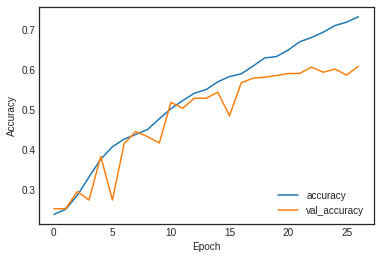

In [ ]:
plt.plot(historyc.history['accuracy'], label='accuracy')
plt.plot(historyc.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = modelc.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

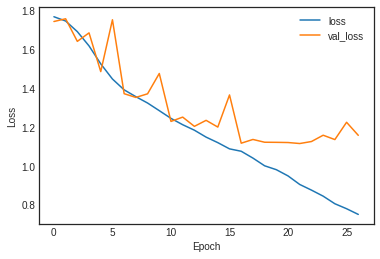

In [ ]:
plt.plot(historyc.history['loss'], label='loss')
plt.plot(historyc.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

#Sources

https://www.kaggle.com/code/basel99/facial-recognition

https://mizykk.tistory.com/55

https://www.kaggle.com/code/apollo2506/facial-recognition

https://www.tensorflow.org/tutorials/images/cnn

https://medium.com/themlblog/how-to-do-facial-emotion-recognition-using-a-cnn-b7bbae79cd8f

https://stackoverflow.com/questions/55776436/keras-cnn-model-is-not-learning


https://medium.com/@ml_kid/how-to-save-our-model-to-google-drive-and-reuse-it-2c1028058cb2